Video Notes:
- end on a note of the webapp
- say i'm going to move to webapp at the end
- ask an audience member for locations
- say 'pooled' ride instead of shared
- double check spelling
- shorter problem slide? could make it more personal. 
- Some visual of a person going from the airport?


This notebook is intended to simulate what the UI will look like and is top-level

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
from scipy.stats import gaussian_kde
import datetime
import pytz
import altair as alt
sns.set()
import matplotlib
matplotlib.rcParams['figure.dpi'] = 144

from datetime import datetime, timedelta

from Fair_Fare.feature_utils import load_hdf
from Fair_Fare.aggregations import bin_on_time_distance
from Fair_Fare.model_utils import get_model_from_file, predict_fare
from Fair_Fare.trips import Stop, Ride
from Fair_Fare.api_interactions import price_estimate_from_lyft, get_current_time_in_chicago


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
models = {"path":"models/", "taxi":"taxi_xgb_full_reduced_params", "rideshare":"tnp_xgb_full_reduced_params" }
data = {"path":"data/","taxi":"taxi_test.h5", "rideshare":"tnp_test.h5" }

taxi_model = get_model_from_file(models['path']+models['taxi'])
taxi_data = load_hdf(data['path']+data['taxi'])

rideshare_model = get_model_from_file(models['path']+models['rideshare'])
rideshare_data = load_hdf(data['path']+data['rideshare'])

# TODO: Consider seperating the binning from the dataframe object
# (should def. do if we switch to SQL database)
rideshare_binned = bin_on_time_distance(rideshare_data)
del(rideshare_data)
taxi_binned = bin_on_time_distance(taxi_data)
del(taxi_data)



## Fair Fare API

Below is a live demo that runs the processing and visualization for a user entered trip.

### Downtown-Downtown Trip

In [100]:
from Fair_Fare.top_level import run_Fair_Fare

USER_PARAMS = {"pickup": "aquarium chicago",
               "dropoff": "the bean cicago",
               "forecast_hrs":1}

In [118]:
results = run_Fair_Fare(USER_PARAMS,rideshare_binned,taxi_binned,taxi_model,rideshare_model)

In [127]:
pd.set_option("display.precision", 2)
print(pd.DataFrame(results[0]).iloc[0])
print(results[0]['Taxi_price_estimate'][0])

Rideshare_pooled_price_estimate     6.12
Rideshare_regular_price_estimate    9.18
Taxi_price_estimate                 9.64
Name: 0, dtype: float64
9.636829


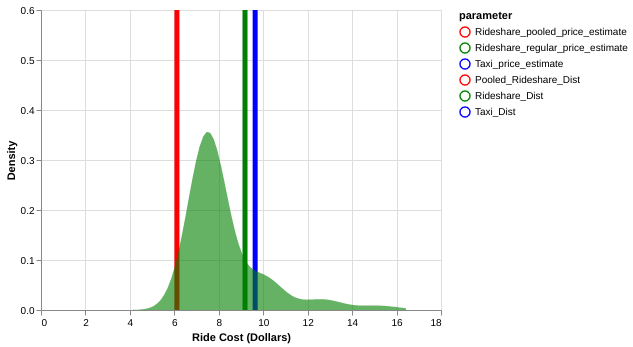

In [119]:

from Fair_Fare.plotting import build_hists_for_altair, build_preds_for_altair, show_viz

rideshare_shared_fares,rideshare_fares,taxi_fares = results[2:5]
fare_dict = {'Pooled_Rideshare_Dist':rideshare_shared_fares, 
             'Rideshare_Dist': rideshare_fares, 'Taxi_Dist': taxi_fares}
predictions = results[0]

show_viz(results,fare_dict, predictions)

### Airport Trip

Rideshare_shared_price_estimate     34.70
Rideshare_regular_price_estimate    49.65
Taxi_price_estimate                 72.21
Name: 0, dtype: float64


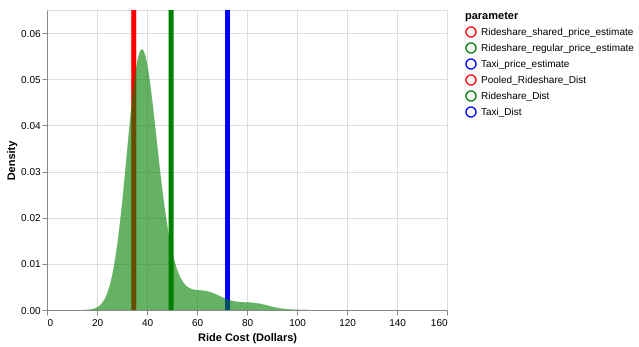

In [72]:
USER_PARAMS = {"pickup": "chicago ohare airport",
               "dropoff": "the bean chicago",
               "forecast_hrs":1}

results = run_Fair_Fare(USER_PARAMS)

pd.set_option("display.precision", 2)
print(pd.DataFrame(results[5]).iloc[0])

rideshare_shared_fares,rideshare_fares,taxi_fares = results[2:5]
fare_dict = {'Pooled_Rideshare_Dist':rideshare_shared_fares, 
             'Rideshare_Dist': rideshare_fares, 'Taxi_Dist': taxi_fares}
predictions = results[5]

show_viz(results,fare_dict, predictions)

### Audience Participation

Rideshare_shared_price_estimate      6.31
Rideshare_regular_price_estimate    11.04
Taxi_price_estimate                 12.30
Name: 0, dtype: float64


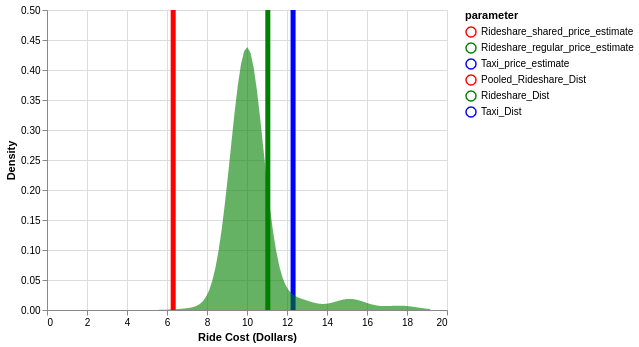

In [64]:
USER_PARAMS = {"pickup": "the bean chicago",
               "dropoff": "the shedd aquarium chicago",
               "forecast_hrs":1}

results = run_Fair_Fare(USER_PARAMS)

pd.set_option("display.precision", 2)
print(pd.DataFrame(results[5]).iloc[0])

rideshare_shared_fares,rideshare_fares,taxi_fares = results[2:5]
fare_dict = {'Pooled_Rideshare_Dist':rideshare_shared_fares, 
             'Rideshare_Dist': rideshare_fares, 'Taxi_Dist': taxi_fares}
predictions = results[5]



In [57]:
def kde(data, nbins = 200):
    data = data[~np.isnan(data)]
    gkde = gaussian_kde(data,bw_method = .5)
    grid = np.linspace(-10,150,nbins)
    kde_vals = gkde.evaluate(grid)
    lo, hi= np.min(data), np.max(data)
    loidx = np.argmin(abs(lo-grid))
    hiidx = np.argmin(abs(hi-grid))
    return {'x':grid, 'y':kde_vals,'valid_range':(lo,hi)}

def build_hists_for_altair(fare_dict):
    df = pd.DataFrame()
    for name, fares in fare_dict.items():
        kde_dict = kde(fares.values)
        df[name] = kde_dict['y']
    df['x'] = kde_dict['x']
    long_df = df.melt(id_vars="x").rename(columns = {"variable":"parameter"})

    return long_df[(long_df.x>kde_dict['valid_range'][0]) & (long_df.x<kde_dict['valid_range'][1])]

build_hists_for_altair(fare_dict)

,x,parameter,value
33,16.53,Pooled_Rideshare_Dist,2.87e-02
34,17.34,Pooled_Rideshare_Dist,3.31e-02
35,18.14,Pooled_Rideshare_Dist,3.73e-02
36,18.94,Pooled_Rideshare_Dist,4.12e-02
37,19.75,Pooled_Rideshare_Dist,4.47e-02
38,20.55,Pooled_Rideshare_Dist,4.76e-02
39,21.36,Pooled_Rideshare_Dist,4.99e-02
40,22.16,Pooled_Rideshare_Dist,5.14e-02
41,22.96,Pooled_Rideshare_Dist,5.22e-02
42,23.77,Pooled_Rideshare_Dist,5.24e-02


### Map

- Requirements:
1. Start latitude, start longitude.
2. Path
3. Histogram data (if we want to embed in the plot, see https://python-visualization.github.io/folium/quickstart.html)

- Returns:
1. HTML-embeddable map of appropriate region and points marked.


In [95]:
import folium

In [101]:
m = folium.Map(location=[41.855615, -87.771084])
folium.Marker([41.855615, -87.771084], popup='<i>Mt. Hood Meadows</i>', tooltip="CATS").add_to(m)

In [105]:
import googlemaps
import json
with open("secrets.json.nogit") as fh:
    secrets = json.loads(fh.read())

gmaps = googlemaps.Client(key=secrets['gmaps_api_key'])

now = datetime.now()
directions_result = gmaps.directions("Sydney Town Hall",
                                    "Parramatta, NSW",
                                    departure_time=now)

In [106]:
directions_result

[{'bounds': {'northeast': {'lat': -33.8132626, 'lng': 151.2060594},
   'southwest': {'lat': -33.8780119, 'lng': 150.987739}},
  'copyrights': 'Map data ©2019 Google',
  'legs': [{'distance': {'text': '25.3 km', 'value': 25287},
    'duration': {'text': '29 mins', 'value': 1726},
    'duration_in_traffic': {'text': '30 mins', 'value': 1797},
    'end_address': 'Parramatta NSW 2150, Australia',
    'end_location': {'lat': -33.8135515, 'lng': 151.0034258},
    'start_address': '483 George St, Sydney NSW 2000, Australia',
    'start_location': {'lat': -33.8727509, 'lng': 151.2060594},
    'steps': [{'distance': {'text': '0.2 km', 'value': 184},
      'duration': {'text': '1 min', 'value': 49},
      'end_location': {'lat': -33.8730216, 'lng': 151.2041188},
      'html_instructions': 'Head <b>west</b> on <b>Druitt St</b> toward <b>Market Row</b>',
      'polyline': {'points': 'twvmE{l{y[?BAp@@PBvBBTFz@@L@LDN@FX|@'},
      'start_location': {'lat': -33.8727509, 'lng': 151.2060594},
      'tr

In [109]:
import polyline
polyline.decode('twvmE{l{y[B~DNlBFVl@|Bp@~CvBdJPbAn@bEl@rFVbBN`@Hd@j@bDFrAAh@Gh@WlA[p@u@|@cBpAwDjCaCbBeBlAq@j@a@h@Yh@Yp@U~@Kr@OdCKt@]nA_@lAsAbEk@zBMl@i@~CqA~HcFvYSvAIdAE|@@r@Fz@N|@|BvIh@vBH^FBHJBLn@zBdBrEZx@`AjBrC`GfBxDhAlClAhCx@zAjBlCt@~A`@nA\\dBLzAN~DJdAJp@TfAXhAVrBF|ADxATrHFbANbA\\rAh@|A\\jAHh@NpADrBGhH]|HW~B[xBGv@AjALhDF|ACpAKbA]|A]|@]l@{@fAe@`@a@Ve@Rm@PcBb@u@Xy@f@sGdGe@j@[j@[r@Sn@QbAYnBSdBKzACfBFlBLpANdAVhAbAtDvA|ELb@tAzD^lAf@hAp@rBf@~@^j@r@|@nAtAdA|AZp@`AlB\\l@b@f@j@t@~BnC`@n@|J|Nn@dBdAjDTdAPjA?\\GhBSpBKp@Sp@u@fBi@hAa@p@wAzByBzCu@|@g@~@oAbDqBrGaApDm@bDkM~s@mAbIwAhI]tBqAtFy@~DqBtIqCtJ}DpM}FlRcAbDq@fBoC~GIZ_BzFyApGoBpHEZaBdReAjKcAnJCLeAvE}@|CiBtFgBlFqDjKiDnJuFtOe@|ACn@g@|A_@xA]hBYlBm@`G[hFU`Cm@~Eu@hEcAvD_@nAmC`Ic@hAuAjDaEvJsDdIsCtF}EjIkBtCsNxRuN~ReClDwAdC_AjBqBrEsCxGgD`I}AdEwFnN{BdFkCpFoDfIoAnCoAfCmCzFmAtCg@|Ai@|AgAtDiAbEu@`DcCnL[dBc@xAq@|A]p@aAdBcBrCmGfKiAfBgGzJkCrEu@~AM^Ut@Y|@c@hB_@tBUpBKnAIjCAnBH~CNtCDrBAlCIfCSnDI|CBtDJpBJlA^hDr@|Fl@vEV|BZtCRhCFhDEhDMdC]lCq@hDm@pBcDdJ}CvI@Vc@~AmD|LSr@MLURSPIUO]MQaAeAiBiAaCsAyPyJeCyASKQAQ?ASO{Bm@yIAYIOCMIoCHgBh@sFxAgKt@iFHu@iAWo@Ms@M]K?CcE_AmA[_ASyBc@mDy@aFgA_Du@BK`@mCRuA')

[(-33.87275, 151.20606),
 (-33.87277, 151.2051),
 (-33.87285, 151.20455),
 (-33.87289, 151.20443),
 (-33.87312, 151.2038),
 (-33.87337, 151.203),
 (-33.87397, 151.20121),
 (-33.87406, 151.20087),
 (-33.8743, 151.19989),
 (-33.87453, 151.19867),
 (-33.87465, 151.19817),
 (-33.87473, 151.198),
 (-33.87478, 151.19781),
 (-33.875, 151.19699),
 (-33.87504, 151.19657),
 (-33.87503, 151.19636),
 (-33.87499, 151.19615),
 (-33.87487, 151.19576),
 (-33.87473, 151.19551),
 (-33.87446, 151.1952),
 (-33.87396, 151.19479),
 (-33.87304, 151.19409),
 (-33.87239, 151.19359),
 (-33.87188, 151.1932),
 (-33.87163, 151.19298),
 (-33.87146, 151.19277),
 (-33.87133, 151.19256),
 (-33.8712, 151.19231),
 (-33.87109, 151.19199),
 (-33.87103, 151.19173),
 (-33.87095, 151.19106),
 (-33.87089, 151.19079),
 (-33.87074, 151.19039),
 (-33.87058, 151.19),
 (-33.87016, 151.18902),
 (-33.86994, 151.1884),
 (-33.86987, 151.18817),
 (-33.86966, 151.18737),
 (-33.86925, 151.18577),
 (-33.86811, 151.18149),
 (-33.86801, 151